In [1]:
#|echo: false

##---- Load all necessary libraries ----##

# math, df, os, misc.
import numpy as np
import pandas as pd
import math
import scipy.io
import os
import random

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# %config InlineBackend.figure_format = 'svg'

# preprocessing data
from sklearn.model_selection import train_test_split

# algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# (uncomment the commands below when printing notebook to pdf)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300

# 1 - Conceptual questions

## 1.A
> **Question:** What's the main difference between boosting and bagging? The random forest belongs to which type?

Both boosting and bagging are used to improve the performance of machine learning models by combining the outputs of multiple models. The main difference between boosting and bagging is that in boosting, models are weighted according to their performance with each new model attempting to correct the errors of the previous ones. Whereas in bagging, each model gets equal weighting and is built independently of the others.

Boosting aims to reduce bias by sequentially training models where each model tries to correct the errors of the previous ones. This is done by adjusting the weights of the training samples based on the errors of the prior models. Bagging aims to reduce variance by training multiple models on different subsets of the data and then averaging the results for regression or taking a majority vote for classification. Each model in bagging is built independently of the others.

Random Forests belong to the bagging type since they consist of many decision trees, each trained on a different bootstrap sample of the training data. During prediction, Random Forests combine the results of all the trees to make the final prediction which reduces variance and improves generalization.

## 1.B
> **Question:** List several ways to prevent overfitting in CART.

1. Pruning: remove branches that don't significantly improve the model's performance on a validation set. This reduces complexity and helps prevent the tree from fitting noise in the training data. There are two main types: pre-pruning which stops tree growth before it becomes too complex and post-pruning which is building a full tree and then removing less important branches.
2. Limit tree depth: set a maximum depth for the tree. This constrains the model's complexity and prevents it from creating too many levels of branching which can lead to overfitting on specific data points.
3. Set minimum samples per leaf: we can require each leaf node to contain a minimum number of samples. This prevents the tree from creating branches for individual or very small groups of samples, improving generalization.
4. Use cross-validation: we can also apply techniques like k-fold cross-validation to estimate the model's generalization performance more accurately. It can be useful in the selection of hyperparameters like tree depth or minimum samples per leaf. We can avoid overfitting in CART if we can assess the model's performance on different subsets of the data.
5. Use ensemble methods: techniques like Random Forests or Gradient Boosting combine multiple trees which can help reduce overfitting compared to a single complex tree. These methods introduce randomness and aggregation to improve generalization. In random forests, we build multiple trees on random subsets of features and data while in gradient boosting, we sequentially build trees that correct errors of previous ones.

## 1.C
> **Question:** Explain how we control the data-fit complexity in the regression tree. Name at least one hyperparameter that we can turn to achieve this goal.

We control the data-fit complexity in the regression tree by pruning since large trees can overfit the training data and small trees underfit or do not capture important structures. When we are growing a large tree, we can stop creating additional branches when a minimum node size is reached and perform pruning by minimizing the cost function:
$$
C_\alpha(S) = \sum_{j=1}^{|J|} \sum_{x_i \in R_j} (y_i - \hat{c}_j)^2 + \alpha|J|
$$
where:

- The first term is a measure of data-fitting error for the $j$-th node
- $|J|$: Number of terminal nodes in tree $J$
- $\alpha > 0$: regularization parameter

The hyperparameter in this case is the minimum node size (or the minimum samples per leaf) which determines the minimum number of samples required to create a leaf node in the decision tree. By setting a higher minimum node size, we can prevent the tree from creating very small nodes that only fit a few training data points which are prone to overfitting and capturing noise instead of underlying patterns. Increasing the minimum node size forces the regression tree to create larger nodes which helps the model generalize better and avoid overfitting. The minimum node size also directly affects the complexity of the regression tree where a higher value results in a simpler tree structure since the algorithm is less likely to create additional splits if the resulting nodes don't meet the minimum size requirement. On the other hand, a lower minimum node size allows the tree to grow deeper and create more complex decision boundaries which can lead to overfitting. This minimum node size hyperparameter helps balance the bias-variance tradeoff in the regression tree model where a higher value leads to a more biased model by restricting the tree's ability to fit the training data closely while a lower value allows for closer fitting but increases the risk of overfitting and high variance.

## 1.D
> **Question:** Explain how OOB errors are constructed and how to use them to understand a good choice for the number of trees in a random forest. Is OOB an error test or training error, and why?

In a random forest model, each tree is trained on a bootstrap sample of the training data, meaning that each tree is trained on a subset of the data created by sampling with replacement. The samples not included in this bootstrap sample are called Out-of-Bag (OOB) samples. After training each tree, we can use it to predict the OOB samples. Since these samples were not used in training that specific tree, the predictions can be considered an unbiased estimate of the model's performance. To get the overall OOB error estimate for the random forest model, we can average the errors of the predictions for the OOB samples across all trees. For classification tasks, this would be the majority vote for the OOB samples. 

To determine the optimal number of trees, we train the random forest model incrementally by adding one tree at a time and calculating the OOB error after each addition. A plot of the OOB error rate against the number of trees can be made to visualize how the error changes. Using this plot, we can select the number of trees where the OOB error stabilizes or starts to decrease very slowly. Adding more trees beyond this point offers diminishing returns in terms of performance improvement. 

OOB error is more similar to a test error than a training error because it is computed on data points that were not used to train the corresponding tree, making it an unbiased estimate of the model's generalization error, similar to how test errors are computed on unseen data. By using OOB samples, we essentially validate each tree with data it hasn’t seen before which is similar to cross-validation. This contrasts with training error which is calculated on the same data used to train the model and typically underestimates the true error.

## 1.E
> **Question:** Explain what the bias-variance tradeoff means in the linear regression setting. 

The bias-variance tradeoff in linear regression involves balancing two types of errors to achieve optimal model performance. Bias refers to errors from overly simplistic models that fail to capture the underlying patterns in the data. This leads to underfitting where the model consistently misses the actual trend. Variance refers to errors from models that are too complex and have too many parameters. These models can become very sensitive to small fluctuations in the training data, causing them to overfit and perform poorly on unseen data.

In linear regression, models with few parameters may have high bias and low variance while models with many parameters like those representing higher-order polynomial terms may have low bias and high variance. The goal is to find a balance that minimizes total prediction error by achieving an optimal tradeoff between bias and variance. For example, if the data has a strong non-linear relationship, then a simple linear model will have high bias because it won't be able to capture the non-linear curve.


# 2 - AdaBoost

Consider the dataset plotted in the following figure. 

![Plot of Labeled Data Points](hw.png){width=50%}

The first two coordinates represent the value of two features, and the last coordinate is the binary label of the data.
$$
\begin{split}
    &X_1 = (-1, 0, +1), X_2 = (-0.5, 0.5, +1), X_3 = (0, 1, -1), X_4 = (0.5, 1, -1), \\
    &X_5 = (1, 0, +1), X_6 = (1, -1, +1), X_7 = (0, -1, -1), X_8 = (0, 0, -1).
\end{split}
$$

In this problem, we will run through $T = 3$ iterations of AdaBoost with decision stumps (as explained in the lecture) as weak learners.

## 2.A
> **Question:** For each iteration $t = 1, 2, 3$, compute $\epsilon_t$, $\alpha_t$, $Z_t$, $D_t$ by hand (i.e., show the calculation steps) and draw the decision stumps on the figure (you can draw this by hand). 

The steps for AdaBoost are given as such:

- Construct $D_t: t = 1, \ldots, T$
- Initialize $D_1(i) = \frac{1}{m}$
- Given $D_t$ and $h_t$, decide weights for classifier
$$
\epsilon_t = \sum_{i=1}^m D_t(i) \mathbb{I}\{y^i \neq h_t(x^i)\}
$$
$$
\alpha_t = \frac{1}{2} \ln \left( \frac{1 - \epsilon_t}{\epsilon_t} \right)
$$

- Update weights for data
$$
D_{t+1}(i) = \frac{D_t(i)}{Z_t} e^{-\alpha_t y^i h_t(x^i)} = \frac{D_t(i)}{Z_t} \times
\begin{cases}
    e^{-\alpha_t} & \text{if } y^i = h_t(x^i) \\
    e^{\alpha_t} & \text{otherwise}
\end{cases}
$$
where $Z_t$ is a normalizing constant $Z_t = \sum_{i=1}^m D_t(i) e^{-\alpha_t y^i h_t(x^i)}$

- Final classifier 
$$
H(x) = \text{sign}\left( \sum_{t=1}^T \alpha_t h_t(x) \right)
$$

**Iteration t = 1**

![AdaBoost t = 1](adaboost/adaboost_t1.png){width=70%}

There were 2 misclassified data points, $X_5$ and $X_6$, as seen in the plot above. 

I can initialize $D_1 = \frac{1}{8}$ for all points.

Decide weights for classifier:

- $\epsilon_1 = \sum_{i=1}^m D_1(i) \mathbb{I}\{y^i \neq h_1(x^i)\} = \frac{1}{8} \times 2 = 0.25$
- $\alpha_1 = \frac{1}{2} \ln \left( \frac{1 - \epsilon_1}{\epsilon_1} \right) = \frac{1}{2}\ln \left( \frac{1 - 0.25}{0.25} \right) = 0.5493$
- $Z_1 = \sum_{i=1}^m D_1(i) e^{-\alpha_1 y^i h_1(x^i)} = \frac{1}{8} \times [6 \times  e^{-0.5493} + 2 \times e^{0.5493}] = 0.8660$

Update weights for data:

- Correctly classified points: 
  
  $D_2(1) = D_2(2) = D_2(3) = D_2(4) = D_2(7) = D_2(8) = \frac{D_1(1)}{Z_1} \times e^{-\alpha_1} = \frac{0.125}{0.8660} \times e^{-0.5493} = 0.0833$

- Misclassified points: 
  
  $D_2(5) = D_2(6) = \frac{D_1(1)}{Z_1} \times e^{\alpha_1} = \frac{0.125}{0.8660} \times e^{0.5493} = 0.2500$

**Iteration t = 2**

![AdaBoost t = 2](adaboost/adaboost_t2.png){width=70%}

There were 2 misclassified data points, $X_1$ and $X_2$, as seen in the plot above. 

Decide weights for classifier:

- $\epsilon_2 = \sum_{i=1}^m D_2(i) \mathbb{I}\{y^i \neq h_2(x^i)\} = 2 \times 0.0833 = 0.1667$
- $\alpha_2 = \frac{1}{2} \ln \left( \frac{1 - \epsilon_2}{\epsilon_2} \right) = \frac{1}{2} \ln \left( \frac{1 - 0.1667}{0.1667} \right) = 0.8047$
- $Z_2 = \sum_{i=1}^m D_2(i) e^{-\alpha_2 y^i h_2(x^i)} = 2 \times 0.0833 \times e^{0.8047} + 4 \times 0.0833 \times e^{-0.8047} + 2 \times 0.2500 \times e^{-0.8047} = 0.7454$

Update weights for data:

- Correctly classified points:

  $D_3(3) = D_3(4) = D_3(7) = D_3(8)= \frac{D_2(3)}{Z_2} \times e^{-\alpha_2} = \frac{0.0833}{0.7454} \times e^{-0.8047} = 0.0500$

  $D_3(5) = D_3(6) = \frac{D_2(5)}{Z_2} \times e^{-\alpha_2} = \frac{0.2500}{0.7454} \times e^{-0.8047} = 0.1500$

- Misclassified points:

  $D_3(1) = D_3(2) = \frac{D_2(i)}{Z_2} \times e^{\alpha_2} = \frac{0.0833}{0.7454} \times e^{0.8047} = 0.2500$

**Iteration t = 3**

![AdaBoost t = 3](adaboost/adaboost_t3.png){width=70%}

There were 2 misclassified data points, $X_7$ and $X_8$, as seen in the plot above. 
 
Decide weights for classifier:

- $\epsilon_3 = \sum_{i=1}^m D_3(i) \mathbb{I}\{y^i \neq h_3(x^i)\} = 2 \times 0.0.500 = 0.1000$
- $\alpha_3 = \frac{1}{2} \ln \left( \frac{1 - \epsilon_3}{\epsilon_3} \right) = \frac{1}{2} \ln \left( \frac{1 - 0.1000}{0.1000} \right) = 1.0986$
- $Z_3 = \sum_{i=1}^m D_3(i) e^{-\alpha_3 y^i h_3(x^i)} = 2 \times e^{-1.0986} \times [0.2500 + 0.0500 + 0.1500] + 2 \times 0.0500 \times e^{1.0986} = 0.6000$

Values of AdaBoost parameters at each timestep:
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|}
    \hline
        t & \epsilon_t & \alpha_t & Z_t & D_t(1) & D_t(2) & D_t(3) & D_t(4) & D_t(5) & D_t(6) & D_t(7) & D_t(8) \\
    \hline
        1 & 0.2500 & 0.5493 & 0.8660 & 0.1250 & 0.1250 & 0.1250 & 0.1250 & 0.1250 & 0.1250 & 0.1250 & 0.1250 \\
    \hline
        2 & 0.1667 & 0.8047 & 0.7454 & 0.0833 & 0.0833 & 0.0833 & 0.0833 & 0.2500 & 0.2500 & 0.0833 & 0.0833 \\
    \hline
        3 & 0.1000 & 1.0986 & 0.6000 & 0.2500 & 0.2500 & 0.0500 & 0.0500 & 0.1500 & 0.1500 & 0.0500 & 0.0500 \\
    \hline
\end{array}
$$

The table above can also be found with equations and formulas in this [Excel](adaboost/adaboost_calcs.xlsx) spreadsheet. 

## 2.B
> **Question:** What is the training error of this AdaBoost? Give a short explanation for why AdaBoost outperforms a single decision stump.

The training error of this AdaBoost is 0 because all data points were classified correctly. We can see this by taking a weighted combination of the weak classifiers:

$$ H(x) = \text{sign}\left( \sum_{t=1}^T \alpha_t h_t(x) \right) $$
$$ H_{\text{final}} = \text{sign}\left( \alpha_1 h_1(x) + \alpha_2 h_2(x) + \alpha_3 h_3(x) \right) $$
$$ H_{\text{final}} = \text{sign}\left( 0.5493 h_1(x) + 0.8047 h_2(x) + 1.0986 h_3(x) \right) $$

Since this combination correctly classifies all the data points, the training error is 0. The plot below is the final classifier and further proves that the training error equals 0.

![AdaBoost Final Classifier](adaboost/adaboost_final.png){width=70%}

AdaBoost outperforms a single decision stump because it combines multiple weak learners where each learner corrects the mistakes of the previous ones. By adjusting the weights of misclassified points and giving more importance to points that are harder to classify, AdaBoost is able to create a strong classifier from multiple weak ones. This iterative process makes sure that later classifiers focus more on the errors made by earlier classifiers which ultimately improves overall performance.


# 3 - Random forest and one-class SVM for email spam classifier

The task for this question is to build a spam classifier using the [UCR email spam dataset](https://archive.ics.uci.edu/ml/datasets/Spambase) which came from the postmaster and individuals who had filed spam. This dataset can be downloaded by following the link above. Headers are not necessary for this problem, but can be obtained by the `spambase.names` file. The collection of non-spam emails came from filed work and personal emails, and hence the word `george` and the area code `650` (Palo Alto, CA) are indicators of non-spam. These are useful when constructing a personalized spam filter. We are free to choose any package for this homework. Note: there may be some missing values. We can just fill in zero. We will use the same train-test split for every part.

In [2]:
#|echo: false

col_names = pd.read_csv("spambase/spambase.names", sep = ":", header = None, skiprows = 33)
col_names = list(col_names.iloc[:, 0])
col_names.append('spam')
data = pd.read_csv('spambase/spambase.data', header = None, names = col_names)
data = data.fillna(0)

X = data.drop('spam', axis = 1)
y = data['spam']

seed = 123456

# split the data into training and testing sets (75/25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)

# print('Shape of training set:', X_train.shape)
# print('Shape of testing set:', X_test.shape)

## 3.A
>**Question:** Build a CART model and visualize the fitted classification tree. Please adjust the plot size/font as appropriate to ensure it is legible. Pruning this tree is not required, and if done reasoning should be stated as to why

CART Misclassification Error: 0.0921


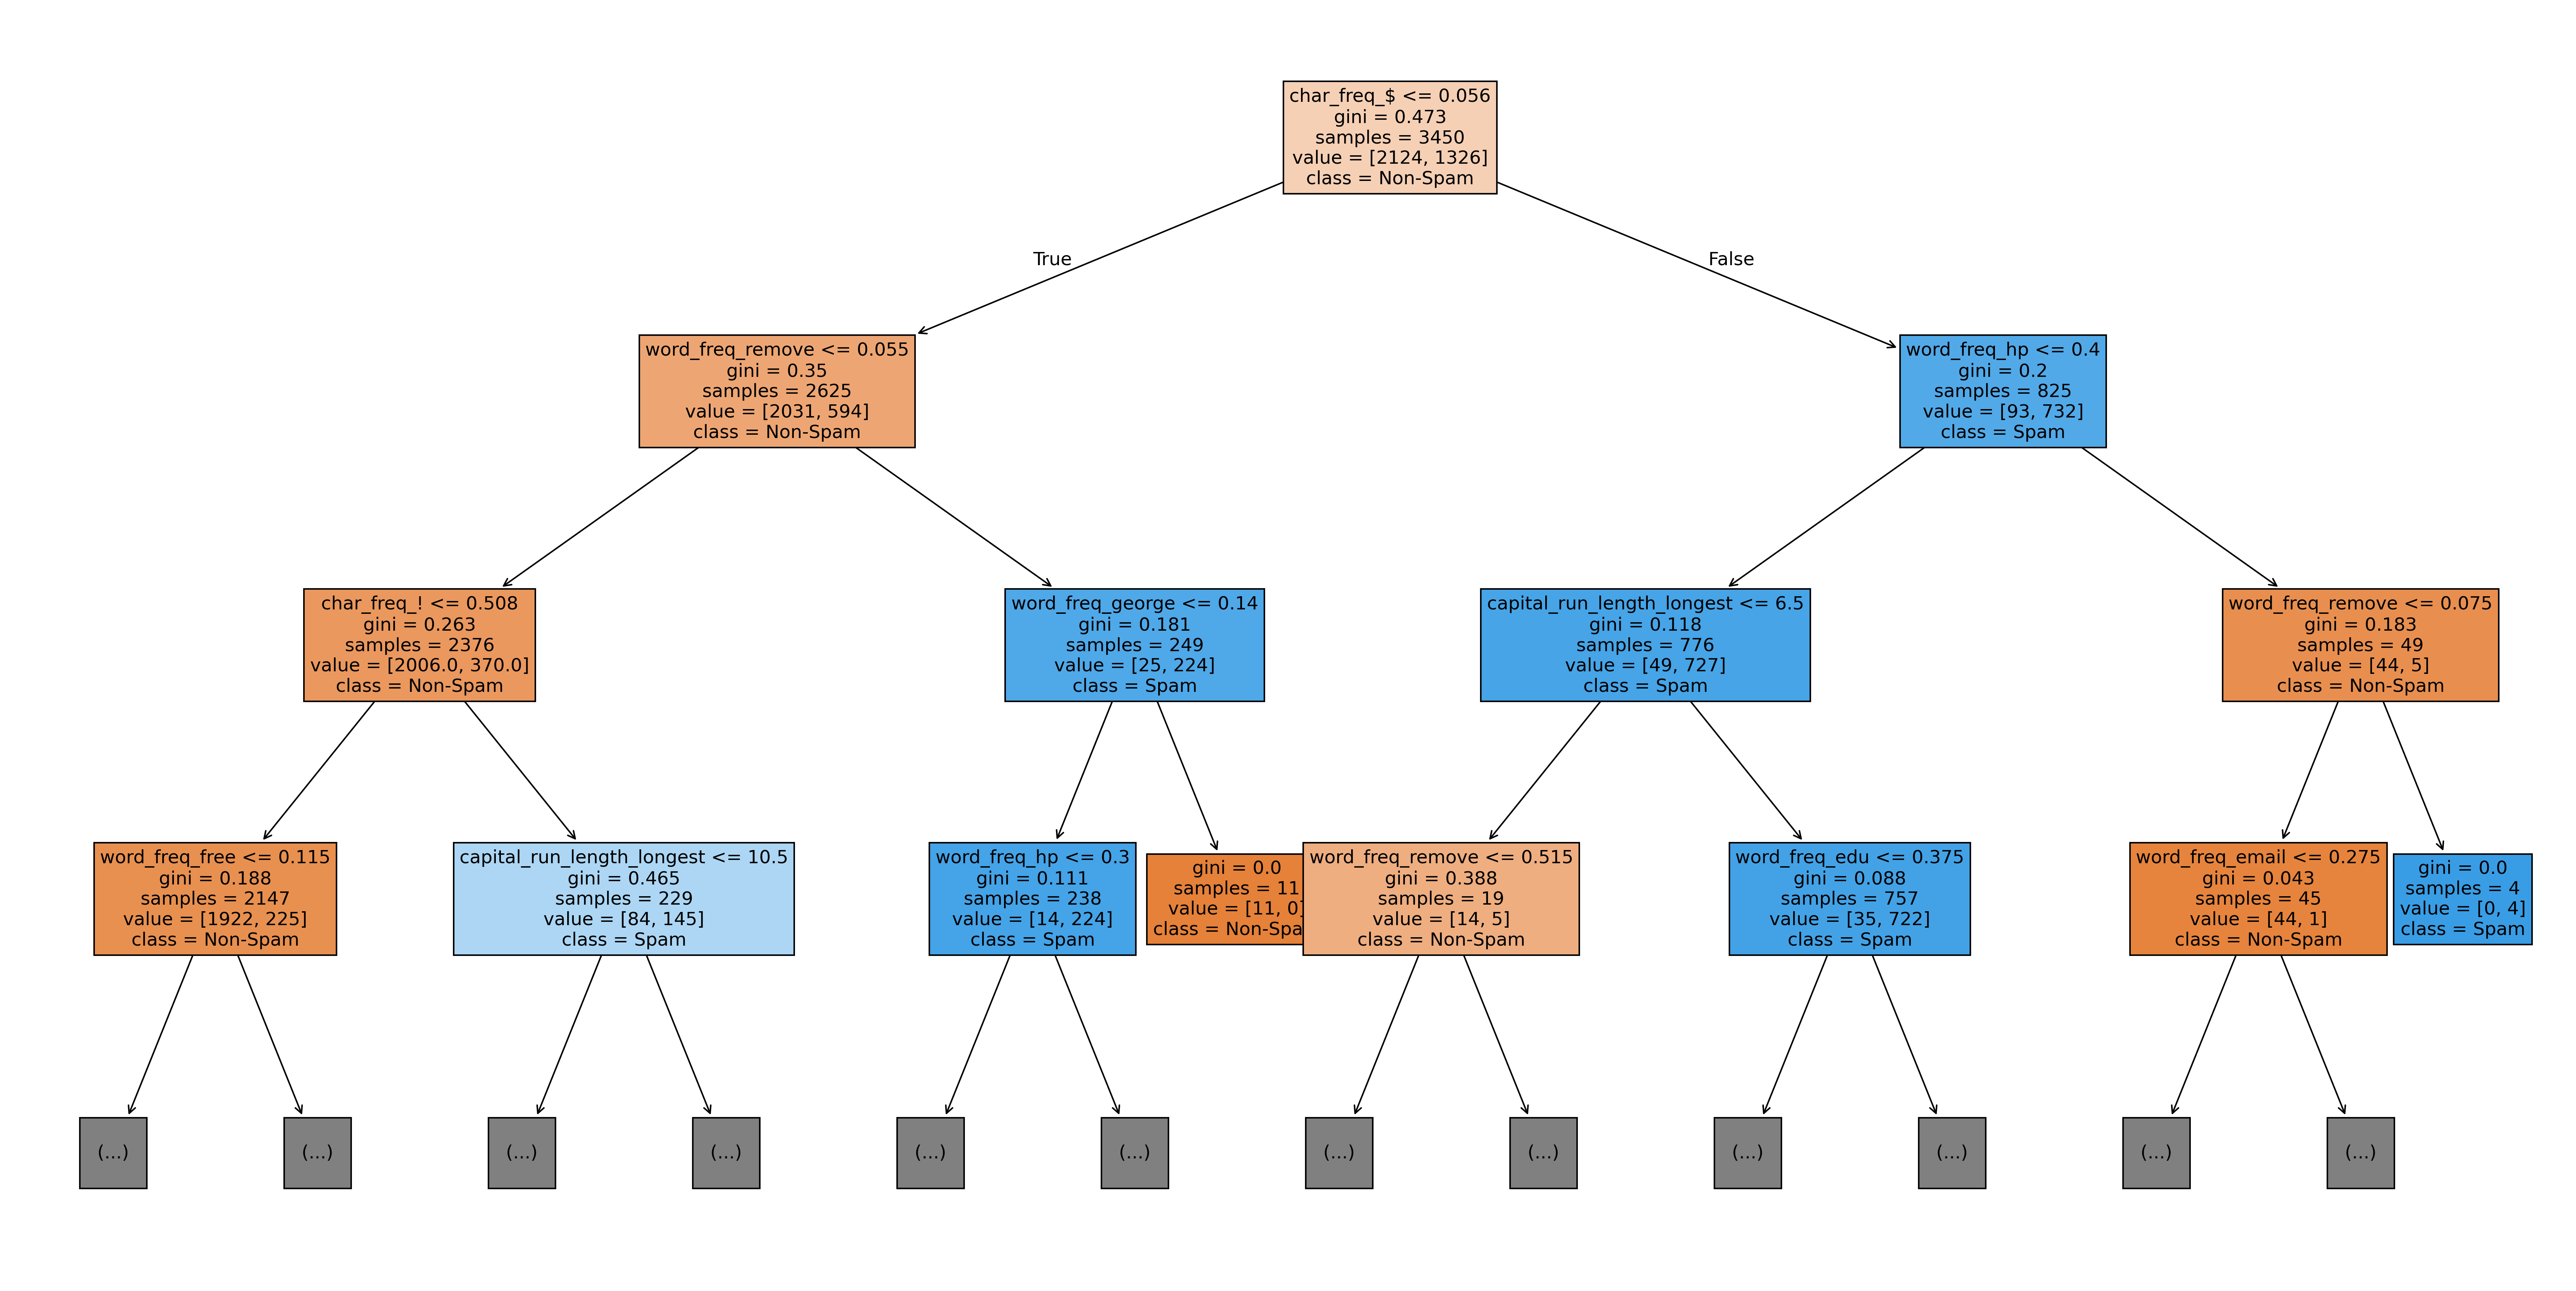

In [3]:
#|echo: false

# Part a

cart = DecisionTreeClassifier(random_state = seed)
cart.fit(X_train, y_train)

cart_error = 1 - cart.score(X_test, y_test)
print(f'CART Misclassification Error: {cart_error:.4f}')

# https://mljar.com/blog/visualize-decision-tree/
fig = plt.figure(figsize=(30,15))
_ = tree.plot_tree(cart, 
                   max_depth = 3,
                   fontsize = 12,
                   feature_names = col_names,  
                   class_names = ['Non-Spam', 'Spam'],
                   filled = True)
# plt.tight_layout()

## 3.B

> **Question:** Now, also build a random forest model. Randomly shuffle the data and partition to use  75% for training and the remaining 25% for testing. Compare and report the test error for your classification tree and random forest models on testing data. Plot the curve of test error (total misclassification error rate) versus the number of trees for the random forest, and plot the test error for the CART model (which should be a constant with respect to the number of trees). 

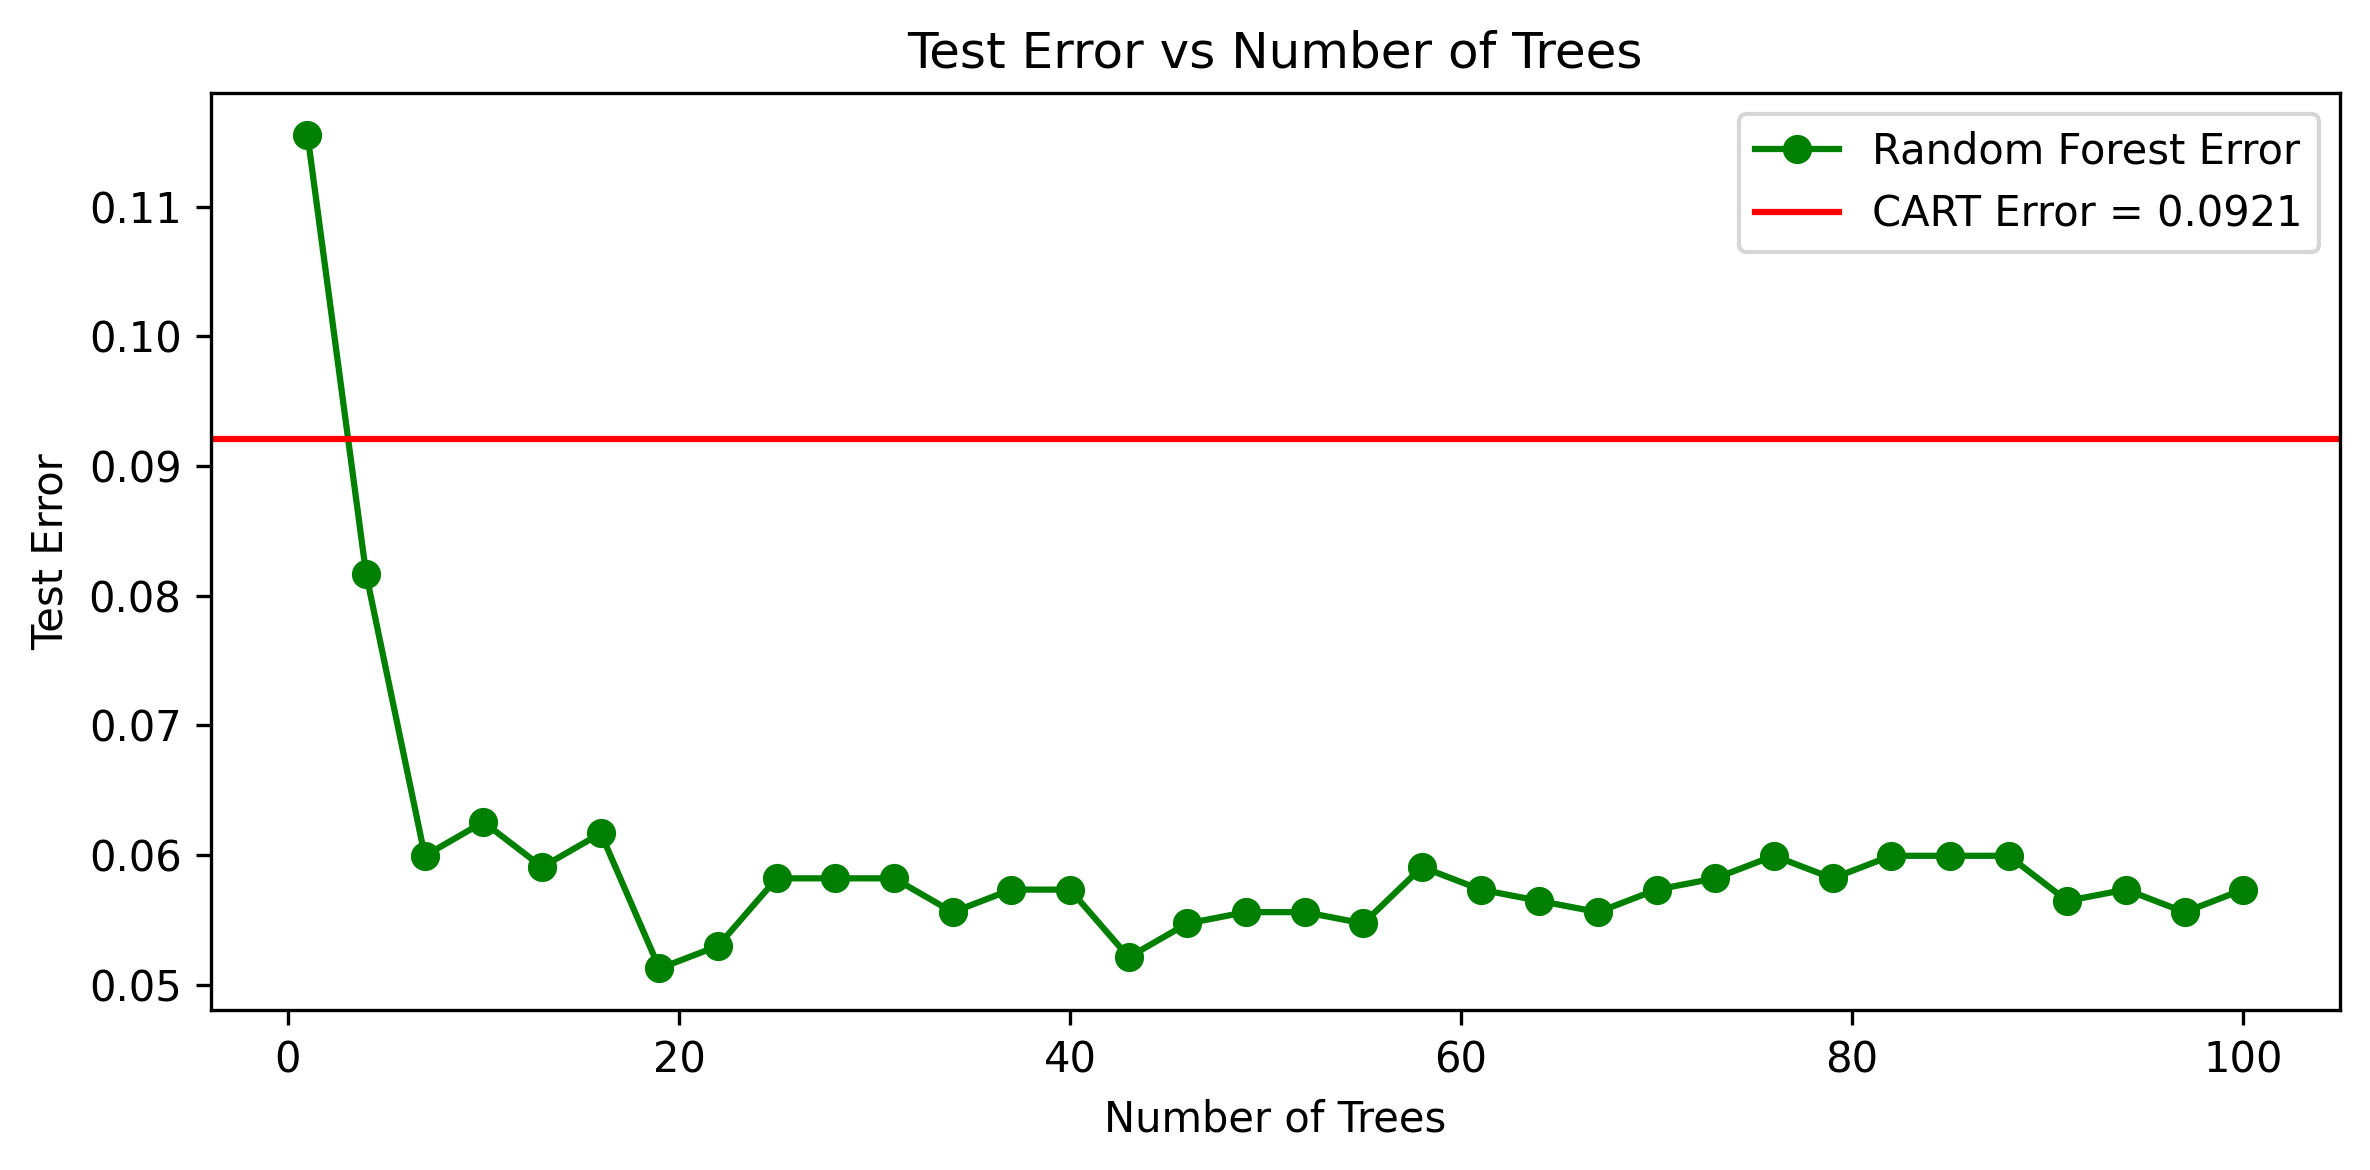

In [4]:
#|echo: false

# Part b

rf_test_errors = []
tree_counts = []

for n in range(1, 102, 3):
    
    rf = RandomForestClassifier(n_estimators = n, random_state = seed)
    rf.fit(X_train, y_train)

    rf_error = 1 - rf.score(X_test, y_test)
    
    # print(n)
    # print(f'Random Forest Misclassification Error: {rf_error}')

    tree_counts.append(n)
    rf_test_errors.append(rf_error)

fig = plt.figure(figsize=(8,4))
plt.plot(tree_counts, rf_test_errors, color = 'g', label = 'Random Forest Error', marker = 'o')
plt.axhline(y = cart_error, color = 'r', label = f'CART Error = {cart_error:.4f}')
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.title('Test Error vs Number of Trees')
plt.legend()
plt.tight_layout()
plt.show()

## 3.C
> **Question:** Fit a series of random-forest classifiers to the data to explore the sensitivity to the parameter $\nu$ (the number of variables selected at random to split). Plot both the OOB error as well as the test error against a suitably chosen range of values for $\nu$.

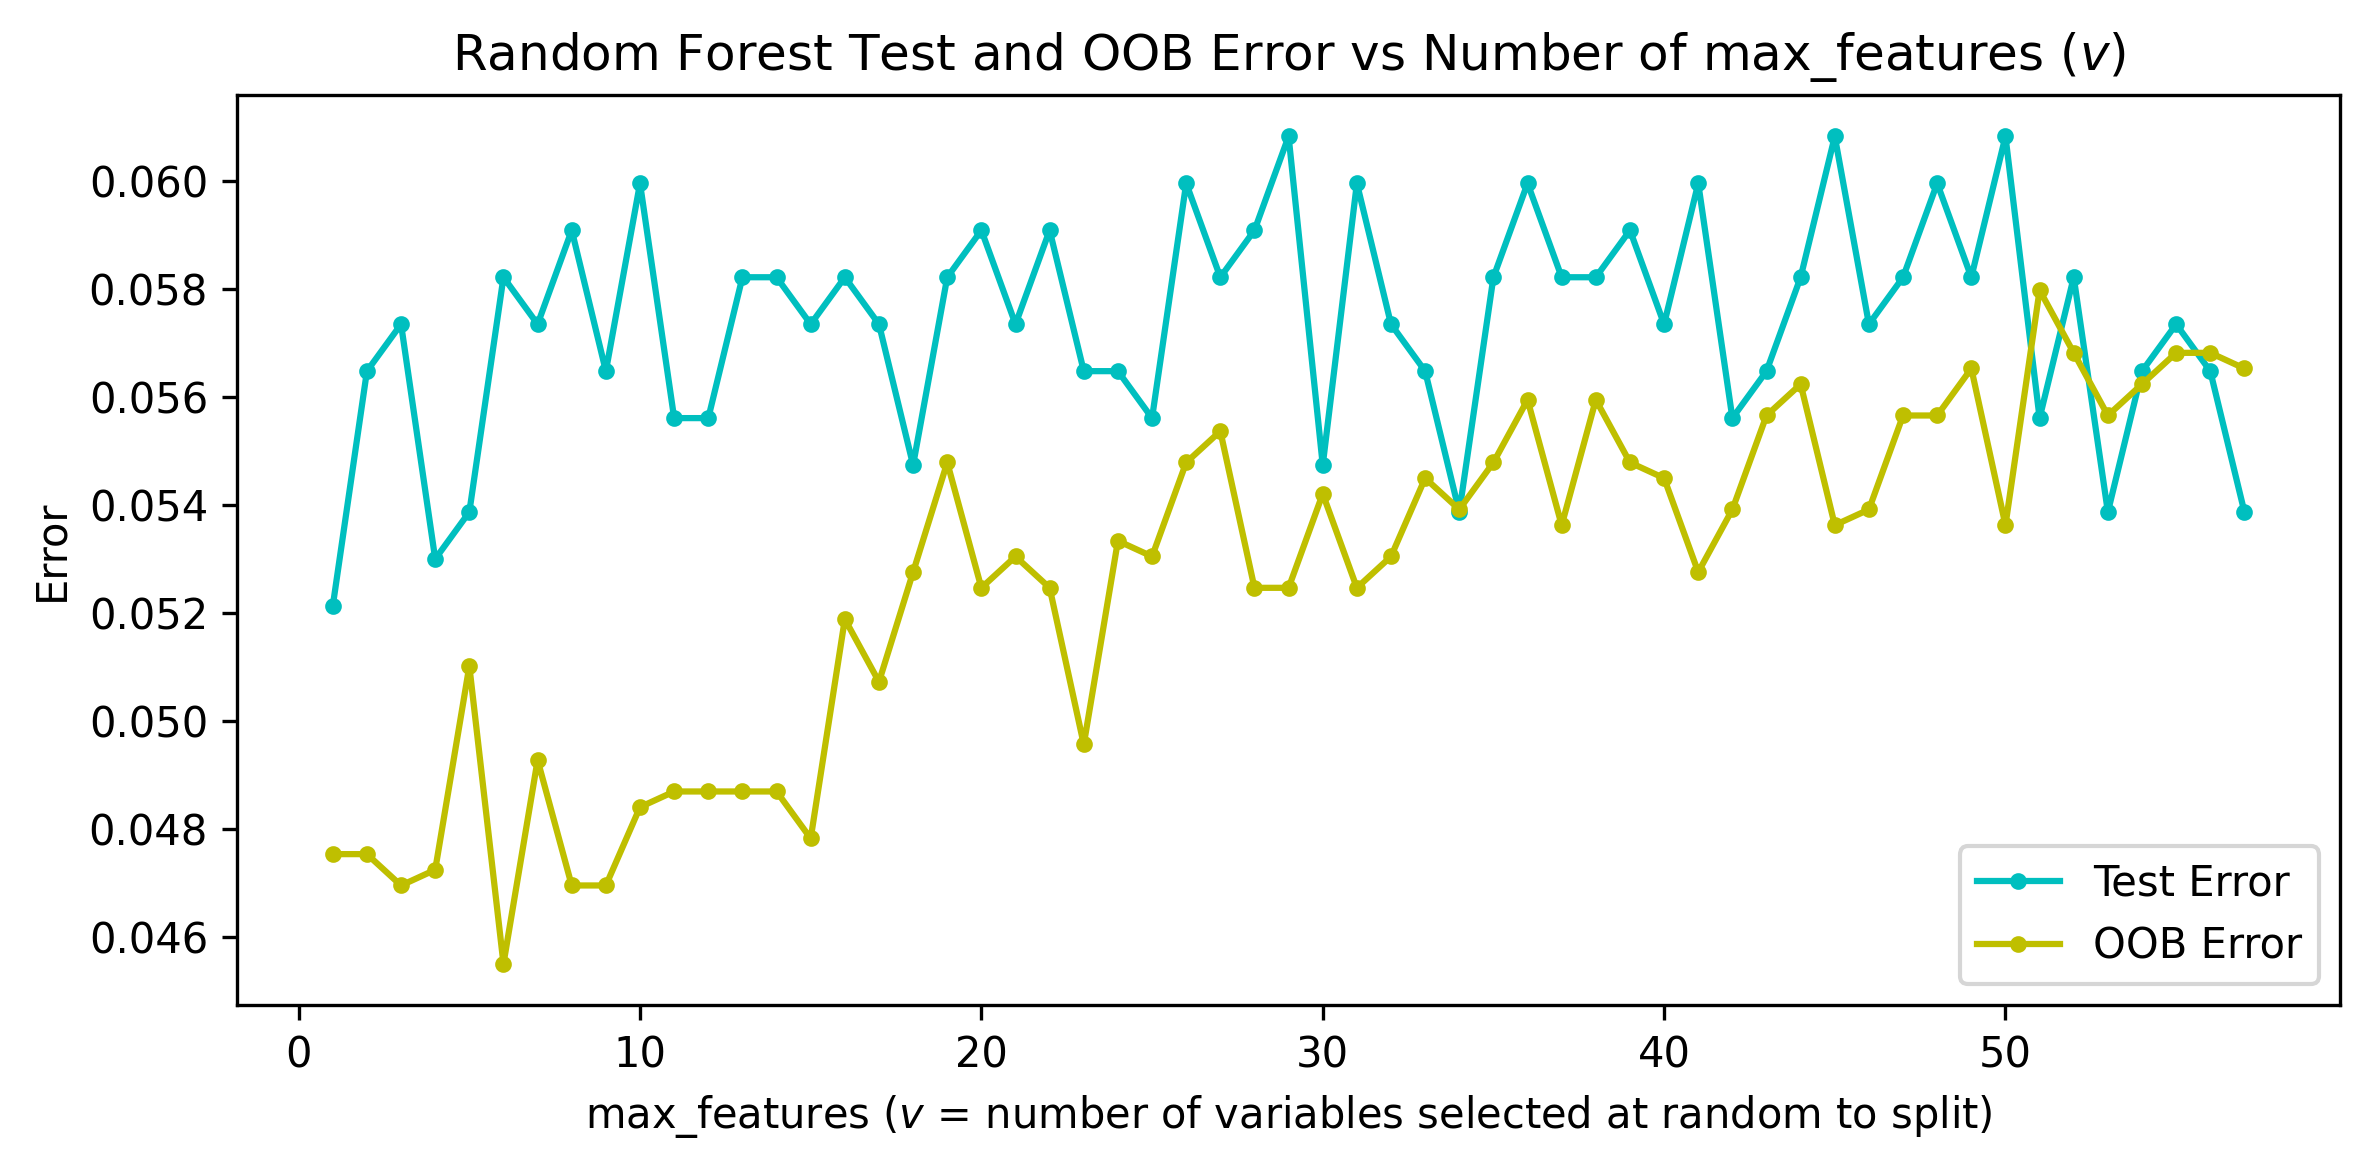

In [5]:
#|echo: false

# Part c

rf_test_errors = []
rf_oob_errors = []
v_counts = []

for v in range(1, len(col_names)):
    
    rf = RandomForestClassifier(max_features = v, random_state = seed, oob_score = True)
    rf.fit(X_train, y_train)

    rf_error = 1 - rf.score(X_test, y_test)
    rf_oob_error = 1 - rf.oob_score_
    
    # print(v)
    # print(f'Random Forest Misclassification Error: {rf_error}')
    # print(f'Random Forest OOB Error: {rf_oob_error}')

    v_counts.append(v)
    rf_test_errors.append(rf_error)
    rf_oob_errors.append(rf_oob_error)

fig = plt.figure(figsize=(8,4))
plt.plot(v_counts, rf_test_errors, color = 'c', label = 'Test Error', marker = '.')
plt.plot(v_counts, rf_oob_errors, color = 'y', label = 'OOB Error', marker = '.')
plt.xlabel('max_features ($v$ = number of variables selected at random to split)')
plt.ylabel('Error')
plt.title('Random Forest Test and OOB Error vs Number of max_features ($v$)')
plt.legend()
plt.tight_layout()
plt.show()

## 3.D

> **Question:** Now, we will use a one-class SVM approach for spam filtering. Randomly shuffle the data and partition to use  75% for training and the remaining 25% for testing. Extract all *non-spam* emails from the training block (75% of data you have selected) to build the one-class kernel SVM using RBF kernel. Then apply it to the 25% of data reserved for testing (thus, this is a novelty detection situation), and report the total misclassification error rate on these testing data. Tune your models appropriately to achieve good performance, i.e. by tuning the kernal bandwidth or other parameters. Give a short explanation on how you reached your final error rate and whether you feel this is a good model.

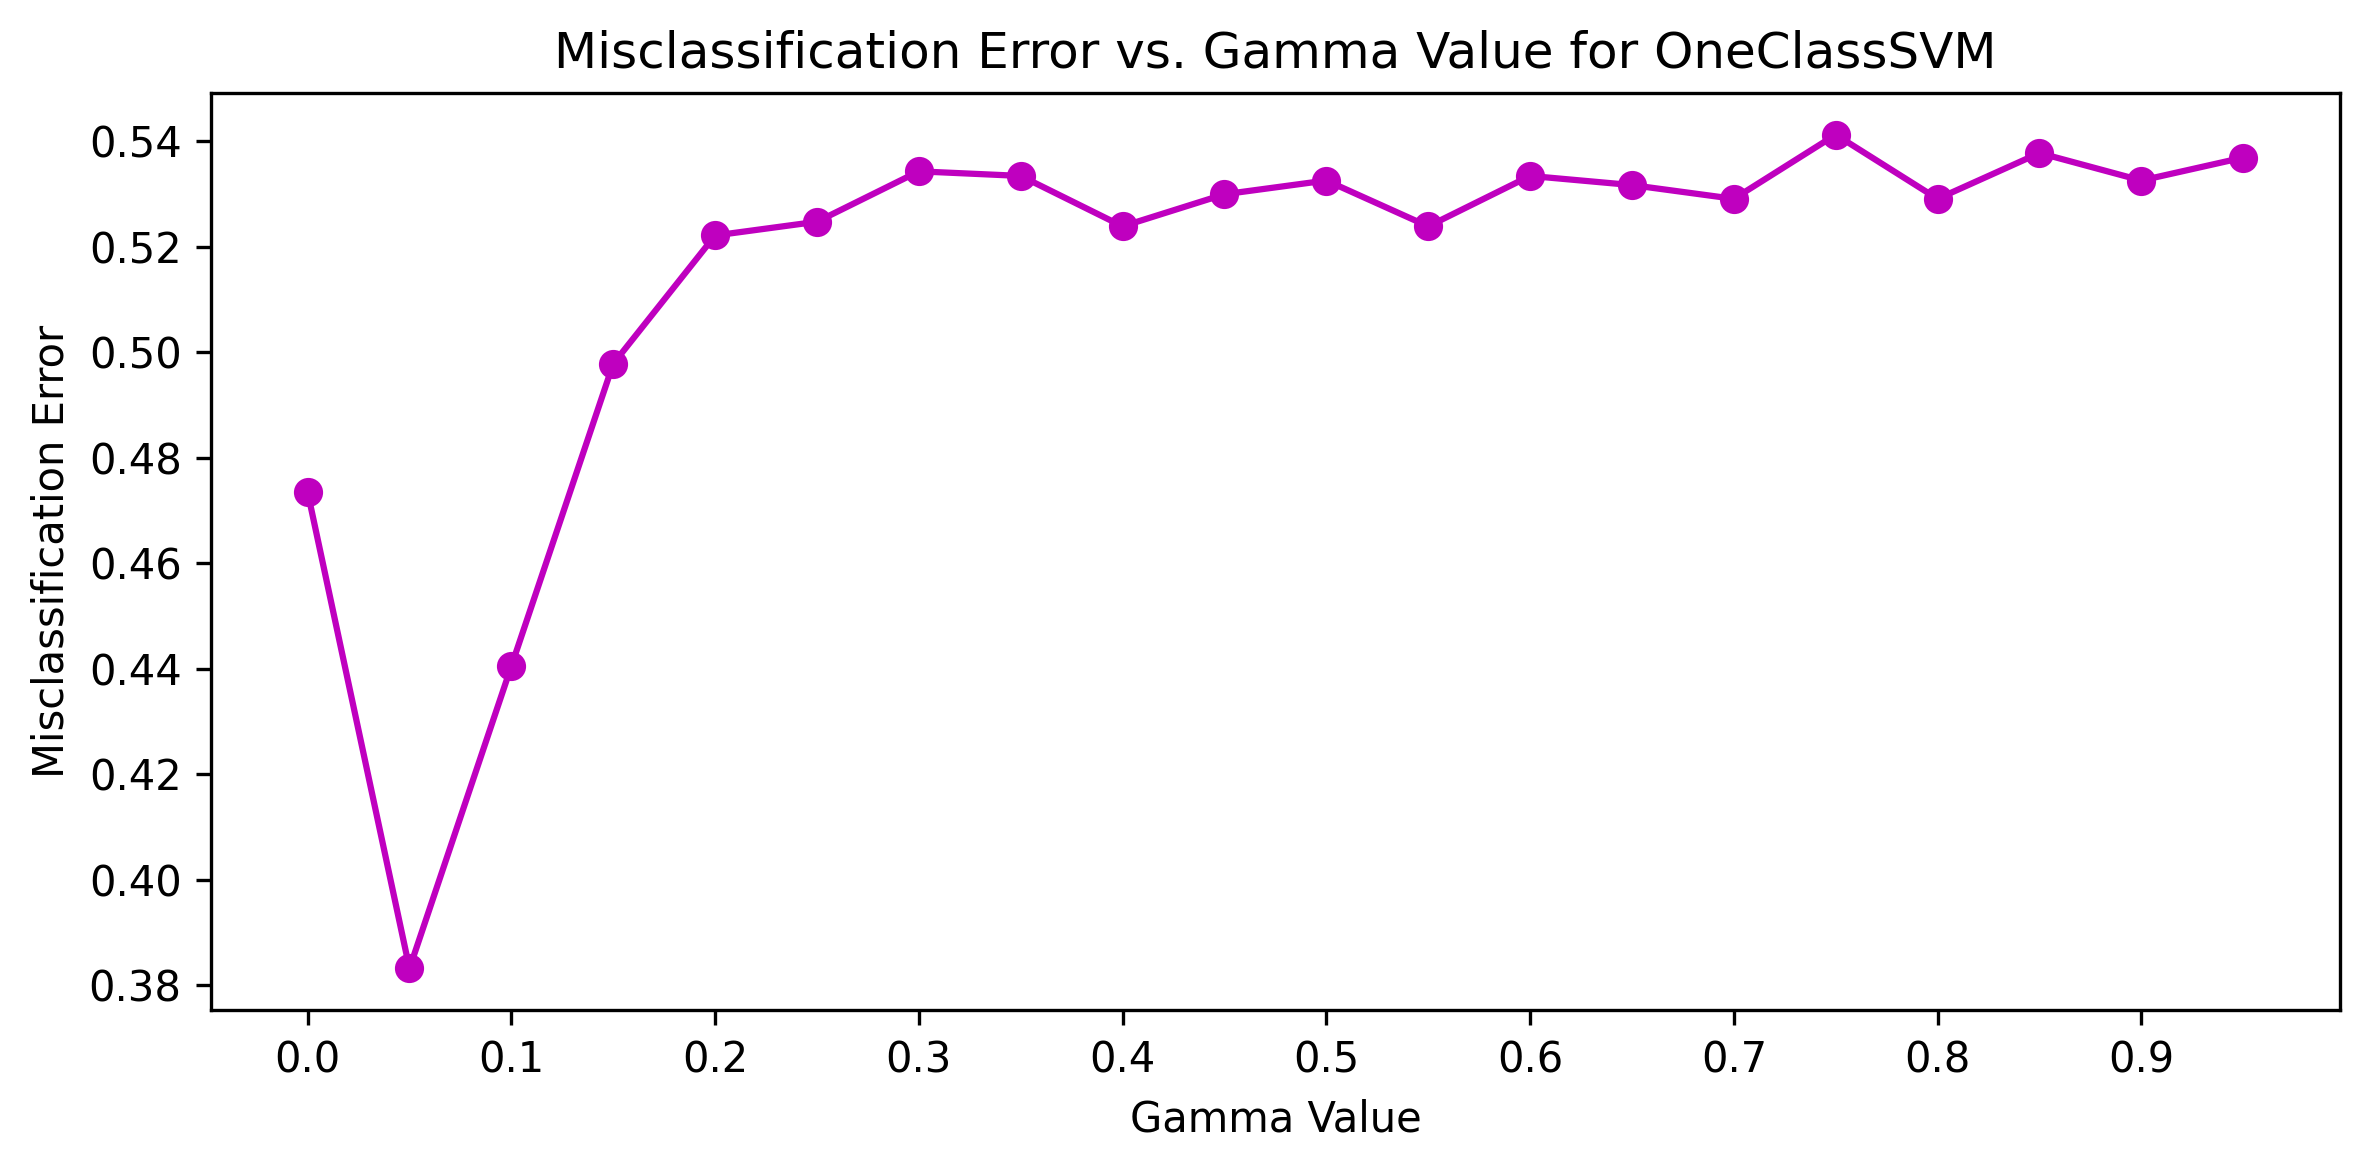

Best gamma: 0.0500, Lowest error: 0.3831


In [6]:
#|echo: false

# Part D

non_spam_X_train = X_train[y_train == 0]

def run_OneClassSVM(X_train, X_test, gamma):

    svm = OneClassSVM(kernel = 'rbf', gamma = gamma)
    svm.fit(non_spam_X_train)
    
    # "Returns -1 for outliers and 1 for inliers." outliers = spam, inliers = non-spam
    svm_preds = svm.predict(X_test)
    
    svm_preds[svm_preds == 1] = 0   # non-spam
    svm_preds[svm_preds == -1] = 1  # spam

    svm_error = 1 - accuracy_score(y_test, svm_preds)
    
    return svm_error

gamma_values = np.arange(0.00001, 1, 0.05)
gamma_errors = {}

for gamma in gamma_values:
    error = run_OneClassSVM(X_train, X_test, gamma)
    gamma_errors[gamma] = error
    # print(gamma, '\t', error)

plt.figure(figsize=(8,4))
plt.plot(gamma_values, list(gamma_errors.values()), color = 'm', marker = 'o')
plt.xticks(np.arange(0, 1, step = 0.1))
plt.xlabel('Gamma Value')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs. Gamma Value for OneClassSVM')
plt.tight_layout()
plt.show()

best_gamma = min(gamma_errors, key = gamma_errors.get)
lowest_error = gamma_errors[best_gamma]
print(f"Best gamma: {best_gamma:.4f}, Lowest error: {lowest_error:.4f}")

I reached my final error rate of 38.31% by testing different gamma values for the `OneClassSVM` function where the gamma value controls the RBF kernel coefficient. I tested values from 0.00001 to 1 with increments of 0.05 and found that the lowest error occurred at a gamma of 0.05. However, this is only for my particular random seed and different seeds may yield lower or higher error rates. I do not feel that this is a good model since the misclassification error is still relatively high compared to the CART and Random Forest models where they had test errors from 4% to 6%. 

# 4 - Locally weighted linear regression and bias-variance tradeoff

The idea of locally weighted linear regression is that we will give more weight to data points in the training data that are close to the point at which we want to make a prediction. This can improve the bias but will also face a bias-variance tradeoff. This homework question is designed to look into this problem. 

Denote data point as $(x_i, y_i)$, $x_i \in \mathbb R^p$,  $i = 1, \ldots, n$. Given a Gaussian kernel function 
$$
K_h(z) = \frac{1}{(\sqrt{2\pi}h)^p} e^{-\frac{\|z\|^2}{2h^2}}, \quad z \in \mathbb R^p.
$$

Local linear regression solves $\beta_0\in \mathbb R$, $\beta_1 \in \mathbb R^p$, for a given predictor $x \in \mathbb R^p$:
$$
\widehat \beta:= (\widehat \beta_0, \widehat\beta_1) = \arg\min \sum_{i=1}^n (y_i - \beta_0 -(x-x^i)^T \beta_1)^2 K_h(x- x_i)
$$

![Illustration of noisy curve](noisy_curve.png){width=80%}

## 4.A
> **Question:** Show that the solution is given in the form
> $$
> \widehat \beta = (X^T  W X)^{-1} X^T W Y
> $$
> for properly defined $X$, $W$, and $Y$ (specify clearly what these need to be).

Given the objective function to minimize:
$$
\sum_{i=1}^n (y_i - \beta_0 - (x - x_i)^T \beta_1)^2 K_h(x - x_i)
$$
$$
\sum_{i=1}^n (y_i - \beta_0 - (x - x_i)^T \beta_1)^2 w_i
$$
where $w_i = K_h(x - x_i)$.

Let $\beta$, $X$, $W$, $Y$:
$$
\beta = \begin{bmatrix} 
            \beta_0 \\ 
            \beta_1 
        \end{bmatrix}
$$

$$
X = \begin{bmatrix}
        1 & (x - x_1)^T \\
        1 & (x - x_2)^T \\
        \vdots & \vdots \\
        1 & (x - x_n)^T
    \end{bmatrix}
$$

$$
W = \begin{bmatrix}
        w_{1} & & \\
        & \ddots & \\
        & & w_{n}
    \end{bmatrix}
$$

$$
Y = \begin{bmatrix}
        y_1 \\
        y_2 \\
        \vdots \\
        y_n
    \end{bmatrix}
$$

Then, the objective function can be written as:
$$
(Y - X \beta)^T W (Y - X \beta)
$$

We can take the derivative of the objective function with respect to $\beta$ and set it to zero:
$$
\frac{\partial}{\partial \beta} (Y - X \beta)^T W (Y - X \beta) = -2 X^T W (Y - X \beta)
$$

$$
-2 X^T W (Y - X \beta) = 0
$$

This simplifies to:
$$
X^T W Y = X^T W X \beta
$$

Solving for $\beta$, we can see that the solution to the local linear regression problem is given by:
$$
\boxed {\beta = (X^T W X)^{-1} X^T W Y}
$$

## 4.B
> **Question:** Use the data.mat file to perform local linear weighted linear regression. Using 5-fold cross validation to tune the bandwidth parameter $h$, report a plot showing your cross validation curve and provide your optimal bandwidth, $h$. 

In [7]:
#|echo: false

# load in data

data = scipy.io.loadmat('data.mat')['data']
X = data[:, 0].reshape(-1, 1)
y = data[:, 1].reshape(-1, 1)

seed = 123456

In [8]:
#|echo: false

def gaussian_kernel(x, x_i, h, p):
    top = np.exp(-np.sum((x - x_i)**2) / (2*h**2))
    bottom = (np.sqrt(2*np.pi)*h)**p

    # print(top/bottom)
    return top/bottom

def locally_weighted_lin_reg(X, y, x, h):
    m = X.shape[0]
    p = X.shape[1]
    # print(m,p)

    # using X, W, Y, and weights from the proof above
    weights = np.array([gaussian_kernel(x, X[i], h, p) for i in range(m)])
    W = np.diag(weights)
    # print(W)

    X_n = np.hstack([np.ones((m, 1)), X - x])
    # print(X_n)
    
    beta = np.linalg.inv(X_n.T @ W @ X_n) @ (X_n.T @ W @ y)

    # print(theta)
    return beta[0]

In [9]:
#|echo: false
#|output: false

def cv_curve(X, y, h_values, k = 5):
    kf = KFold(n_splits = k, shuffle = True, random_state = seed)
    mean_errors = []

    for h in h_values:
        print(f"h: {h}")

        errors = []
        fold_count = 1
        for train_index, val_index in kf.split(X):
            
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # print(len(train_index), len(val_index))

            preds = np.array([locally_weighted_lin_reg(X_train, y_train, X_val[i], h) for i in range(len(X_val))])
            error = np.mean((y_val - preds)**2)

            print(f"fold: {fold_count}, error: {error}")
            fold_count += 1

            errors.append(error)

        mean_errors.append(np.mean(errors))
        print(f"mean error: {np.mean(errors)}\n")

    return mean_errors

# bandwidth values to test
h_values = np.linspace(0.1, 1.0, 50)

cv_errors = cv_curve(X, y, h_values)

h: 0.1
fold: 1, error: 0.00998169279718668
fold: 2, error: 0.015623716408678073
fold: 3, error: 0.01361918994123179
fold: 4, error: 0.012926555489113542
fold: 5, error: 0.014945748535547592
mean error: 0.013419380634351535

h: 0.11836734693877551
fold: 1, error: 0.009864916237603393
fold: 2, error: 0.015605709061240864
fold: 3, error: 0.01335143285351124
fold: 4, error: 0.012885302647356817
fold: 5, error: 0.01434092562463438
mean error: 0.01320965728486934

h: 0.13673469387755102
fold: 1, error: 0.00980503684264335
fold: 2, error: 0.01550203330732807
fold: 3, error: 0.013211069969862113
fold: 4, error: 0.012950409719926814
fold: 5, error: 0.01393788188717004
mean error: 0.013081286345386078

h: 0.15510204081632656
fold: 1, error: 0.009786115913650507
fold: 2, error: 0.015374917149174886
fold: 3, error: 0.013128789029073024
fold: 4, error: 0.012995865900190171
fold: 5, error: 0.01365927346238852
mean error: 0.01298899229089542

h: 0.17346938775510207
fold: 1, error: 0.00979440077822139

Optimal bandwidth (h): 0.210204


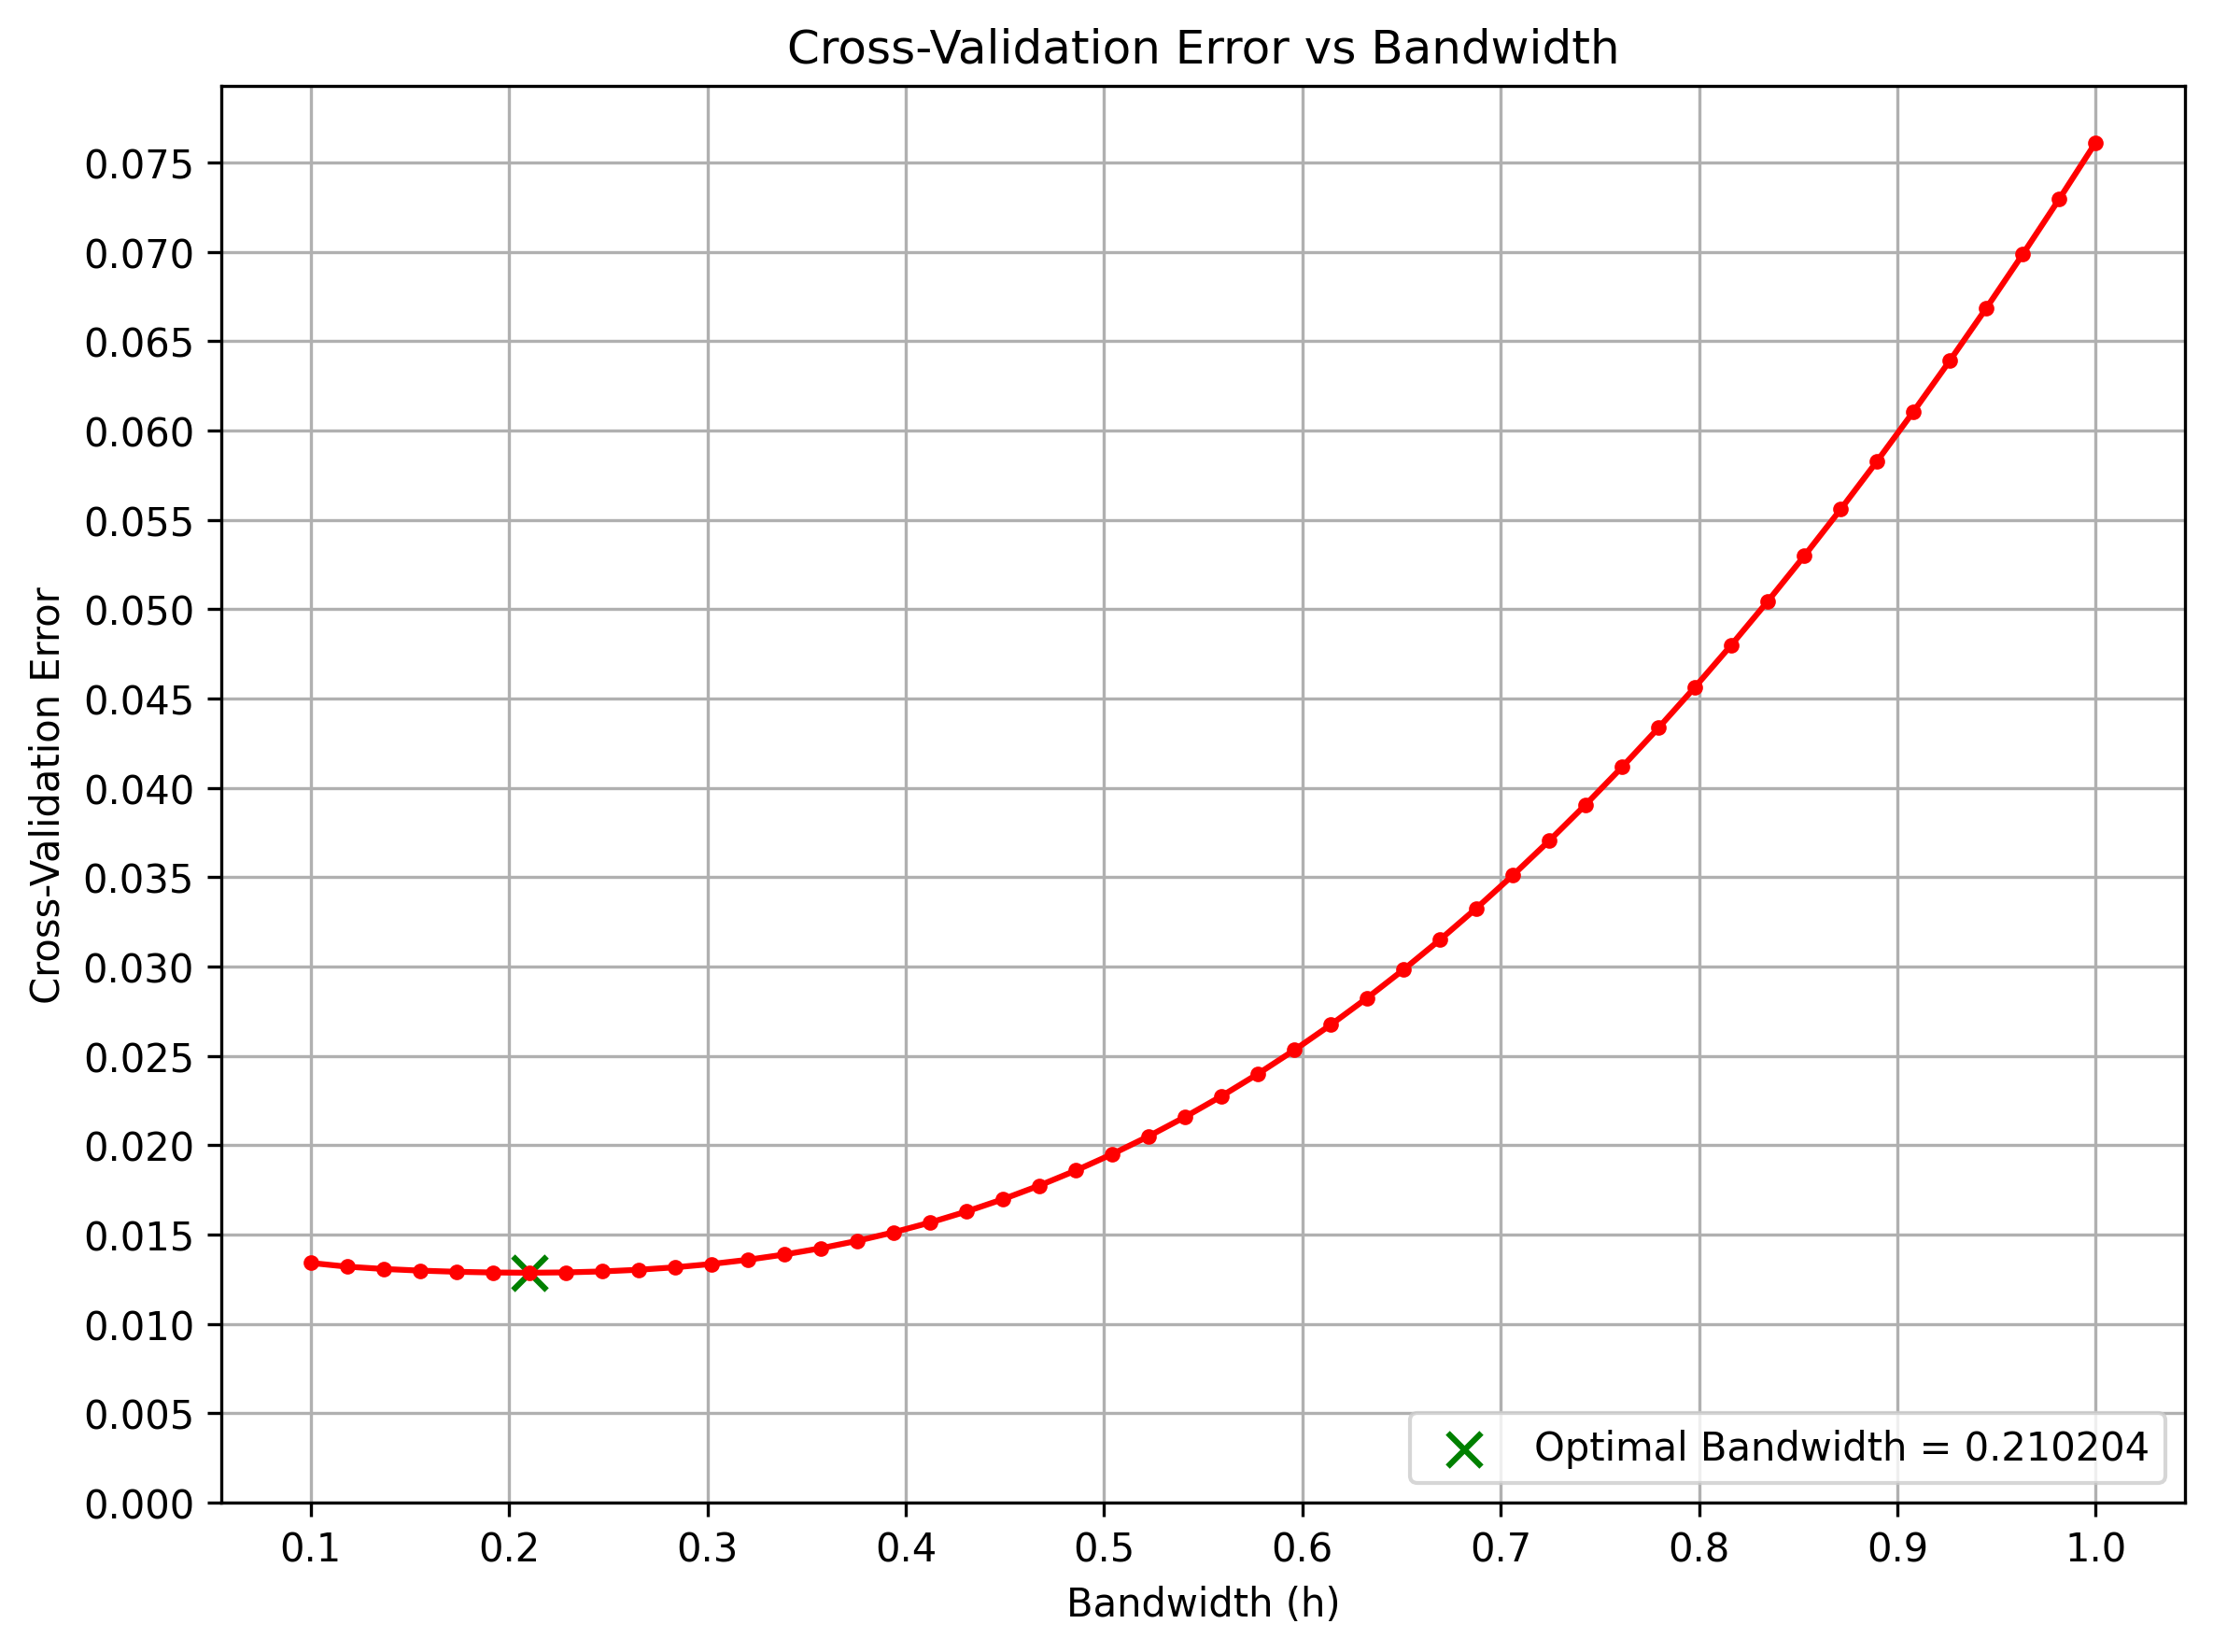

In [10]:
#|echo: false

#  optimal bandwidth
optimal_h = h_values[np.argmin(cv_errors)]
print(f"Optimal bandwidth (h): {optimal_h:3f}")

fig = plt.figure(figsize=(8,6))
plt.plot(h_values, cv_errors, marker = '.', color = 'r')
# plt.axvline(x = optimal_h, color = 'g', linestyle = '--', label = f'Optimal Bandwidth = {optimal_h:3f}', alpha = 0.7)
plt.scatter(optimal_h, np.min(cv_errors), marker = 'x', c = 'green', s = 75, label = f'Optimal Bandwidth = {optimal_h:3f}')

plt.xlabel('Bandwidth (h)')
plt.ylabel('Cross-Validation Error')
plt.xticks(np.arange(0.1, 1.1, step = 0.1))
plt.yticks(np.arange(0, max(cv_errors), step = 0.005))
plt.title('Cross-Validation Error vs Bandwidth')
plt.grid()
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

## 4.C
> **Question:** Using the tuned hyper-parameter $h$, make a prediction for $x = -1.5$. Provide the predicted y value, and report a plot showing your training data, prediction curve, and a marker indicating your prediction.

Using optimial bandwidth (h) = 0.210204
Predicted y for x = -1.5: 1.81214


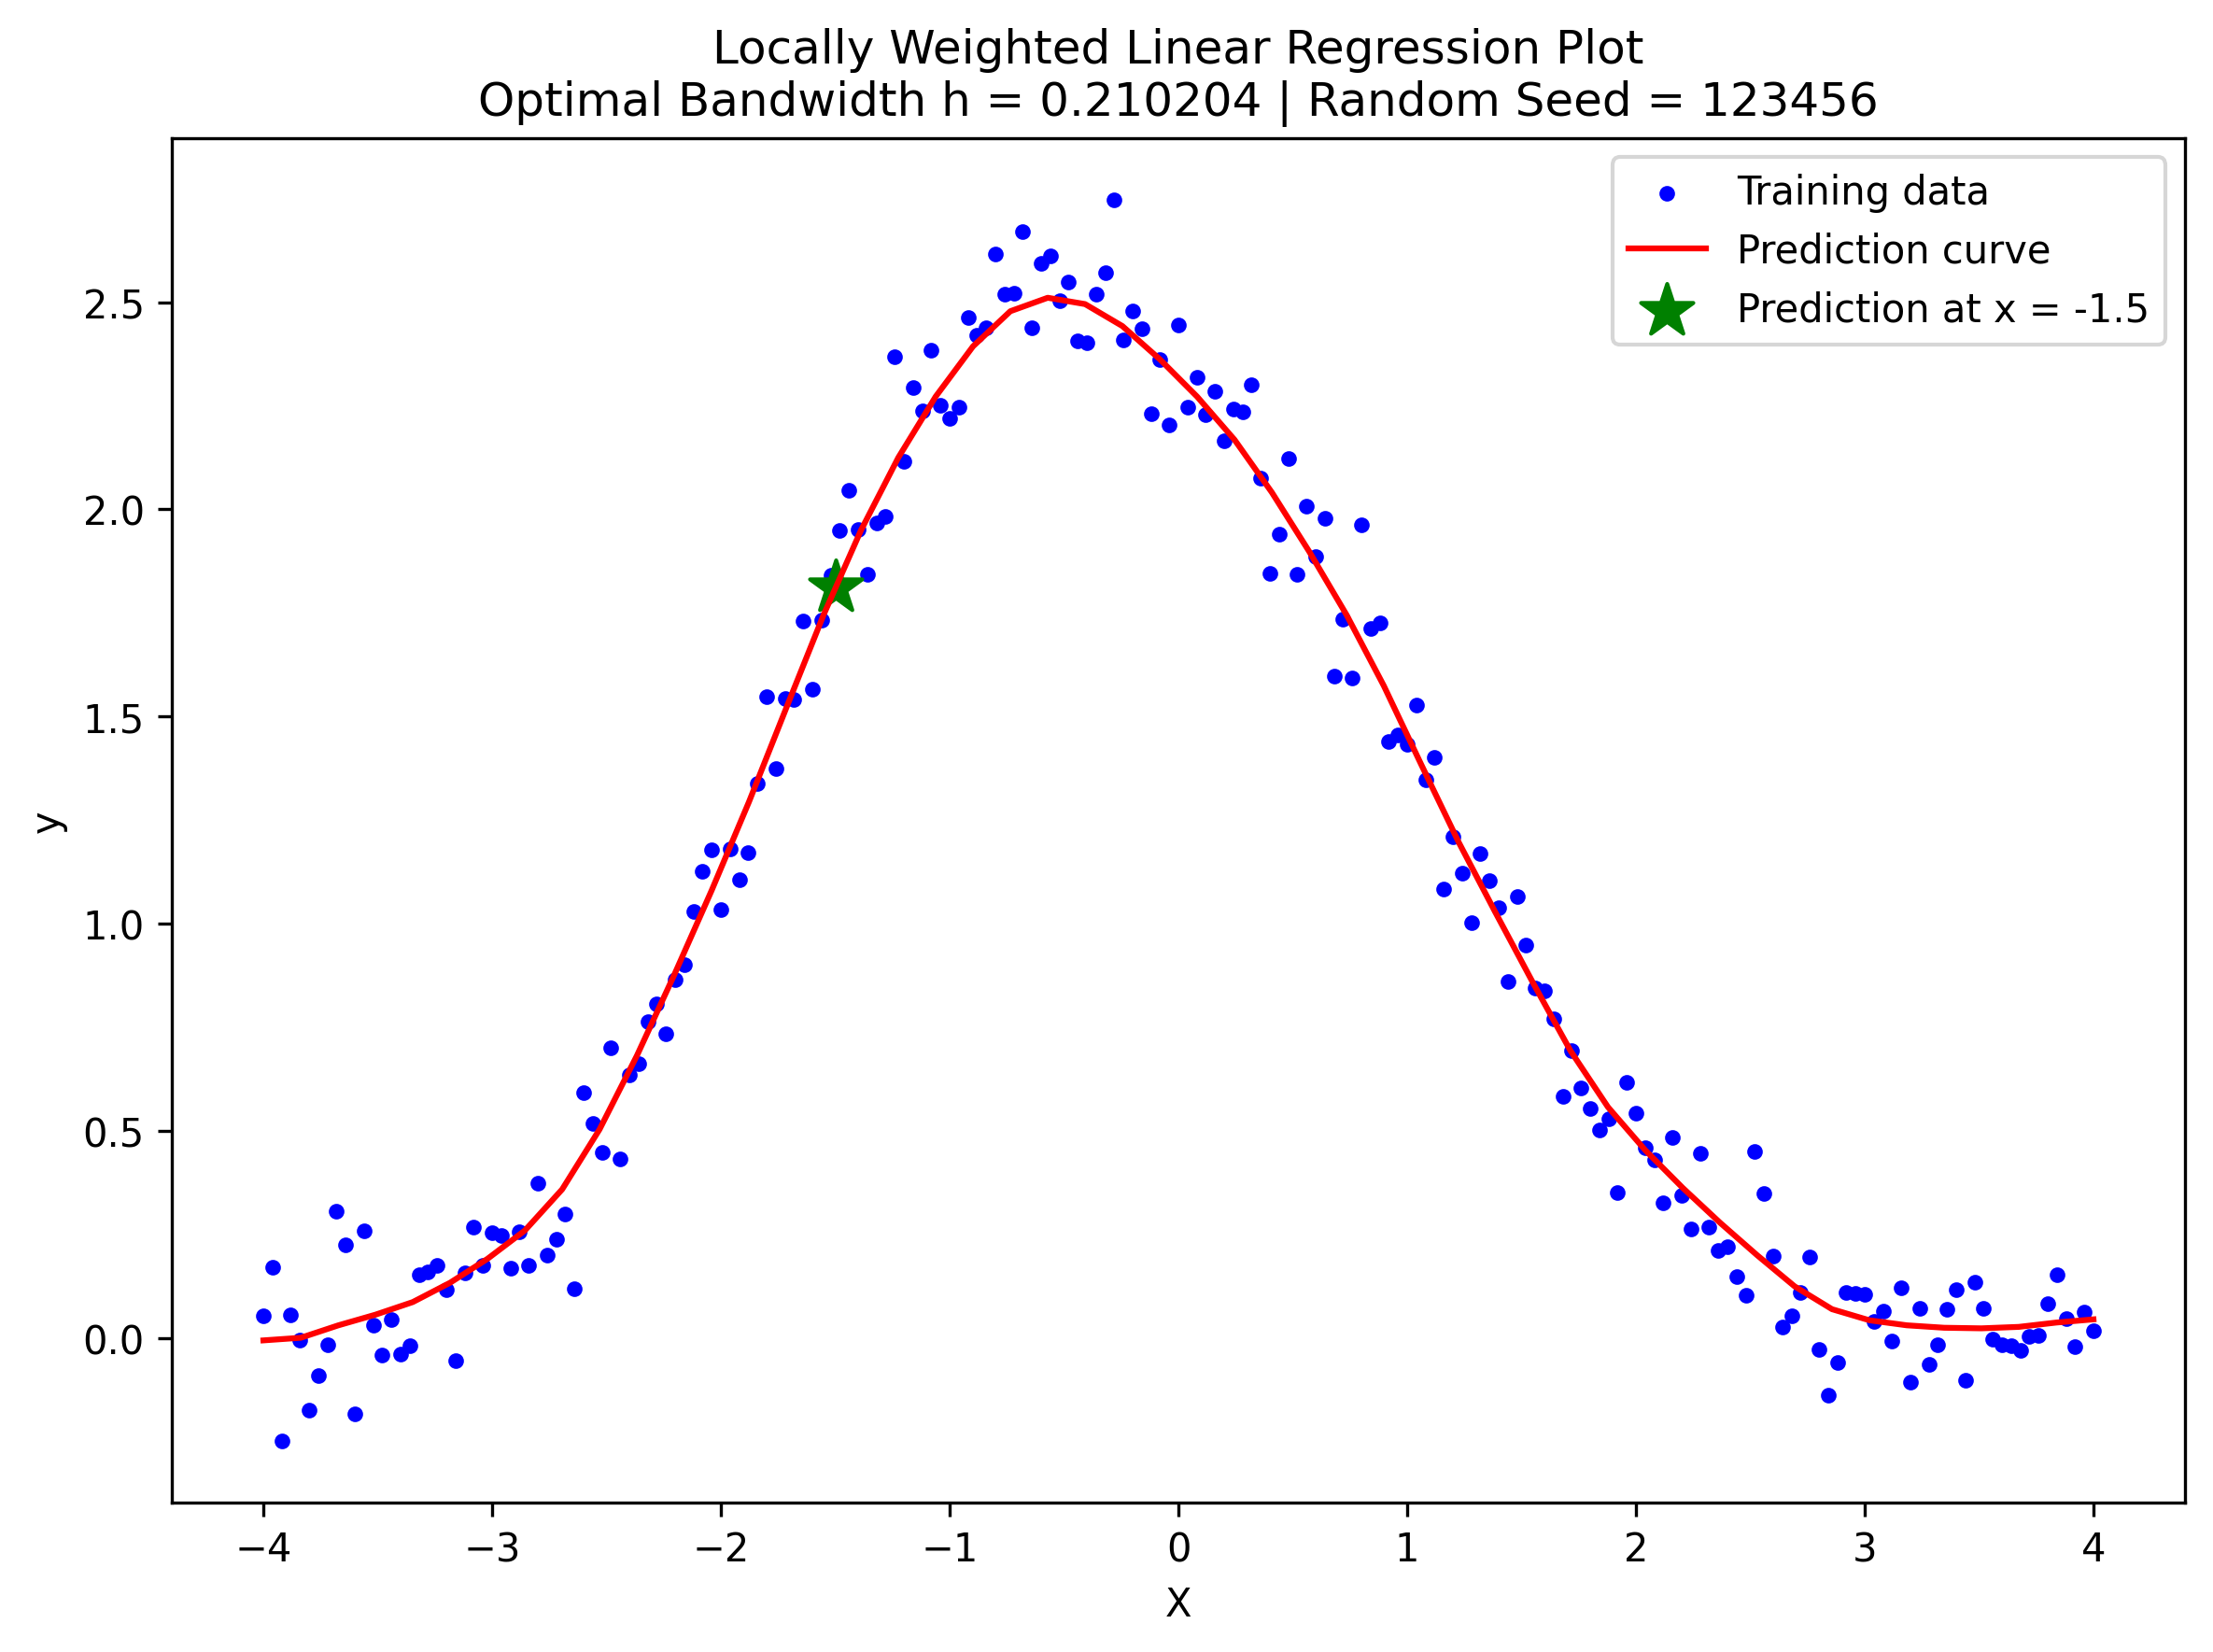

In [11]:
#|echo: false

x_test = np.array([-1.5])
predicted_y = locally_weighted_lin_reg(X, y, x_test, optimal_h)
print(f"Using optimial bandwidth (h) = {optimal_h:3f}\nPredicted y for x = {x_test[0]}: {predicted_y[0]:.5f}")

# plot the curve with training data and prediction marker
x_vals = np.linspace(X.min(), X.max()).reshape(-1, 1)
y_vals = np.array([locally_weighted_lin_reg(X, y, x, optimal_h) for x in x_vals])

fig = plt.figure(figsize=(8,6))
plt.scatter(X, y, color = 'blue', label = 'Training data', marker = '.')
plt.plot(x_vals, y_vals, color = 'red', label = 'Prediction curve')
plt.scatter(x_test, predicted_y, color = 'green', marker = '*', s = 200, label=f'Prediction at x = {x_test[0]}')
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Locally Weighted Linear Regression Plot\nOptimal Bandwidth h = {optimal_h:3f} | Random Seed = {seed}')
plt.legend()
plt.tight_layout()
plt.show()